In [117]:
import numpy as np
import pandas as pd

In [118]:
data = pd.read_csv("genetech.batch_norm_genes.tsv", sep="\t")

In [119]:
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

def negative_log_partial_likelihood(censor, risk):
    """Return the negative log-partial likelihood of the prediction
    y_true contains the survival time
    risk is the risk output from the neural network
    censor is the vector of inputs that are censored
    regularization is the regularization constant (not used currently in model)

    Uses the Keras backend to perform calculations

    Sorts the surv_time by sorted reverse time
    """

    # calculate negative log likelihood from estimated risk
    epsilon = 0.001
    hazard_ratio = K.exp(risk + epsilon)

    # cumsum on sorted surv time accounts for concordance
    log_risk = K.log(tf.cumsum(hazard_ratio))
    uncensored_likelihood = risk - log_risk

    # apply censor mask: 1 - dead, 0 - censor
    censored_likelihood = uncensored_likelihood * censor
    num_observed_events = K.sum(censor)
    neg_likelihood = - K.sum(censored_likelihood) / \
        tf.cast(num_observed_events, tf.float32)
    return neg_likelihood

surv_model = load_model("/Users/Peter/Documents/GitHub/risk/models/batch_norm.hdf5", custom_objects={
                                        'negative_log_partial_likelihood': negative_log_partial_likelihood})

In [120]:
surv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               400384    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 564,737
Trainable params: 564,737
Non-trainable params: 0
_________________________________________________________________


In [121]:
from lifelines.utils import concordance_index

def concordance_metric(survival_time, predicted_risk, censor):
    # calculate the concordance index
    epsilon = 0.001
    partial_hazard = np.exp(-(predicted_risk+epsilon)).flatten()
    censor = censor.astype(int)
    ci = concordance_index(survival_time, partial_hazard, censor)
    return ci


clinical = pd.read_csv("IMvigor210.clinical", sep="\t")
predictions = surv_model.predict(data)
concordance_metric(clinical["OS"], predictions, clinical['Event'])

0.5064460510589941

In [36]:
# taking out the last 2 layers
from keras.models import Model
inp = surv_model.input
output = surv_model.layers[-3].output
model = Model(inp, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 781)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               400384    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
Total params: 564,608
Trainable params: 564,608
Non-trainable params: 0
_________________________________________________________________


In [91]:
results = model.predict(data)
idx = ~np.isnan(clinical["Response"])
# clinical = clinical.values
clinical = clinical.loc[idx,]
results = results[idx,]

In [111]:
import time

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=800)
tsne_results = tsne.fit_transform(results)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 298 samples in 0.001s...
[t-SNE] Computed neighbors for 298 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 298 / 298
[t-SNE] Mean sigma: 88.122293
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.689865
[t-SNE] KL divergence after 800 iterations: 0.550497


In [112]:
clinical.columns

Index(['OS', 'Event', 'Response', 'Best', 'Gender', 'PDL1', 'Mutation',
       'Neoantigen', 'BCG', 'ECOG', 'Smoke', 'Sample', 'Platinum',
       'Sample_Pre-Platinum', 'Tissue'],
      dtype='object')

No handles with labels found to put in legend.


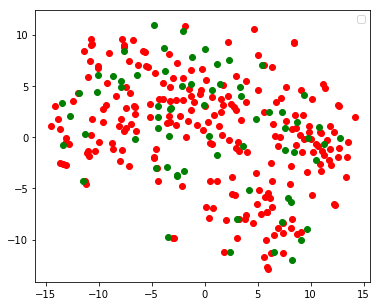

In [114]:
clinical_feature = clinical['Response']

target_ids = range(int(min(clinical_feature)), int(max(clinical_feature))+1)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(tsne_results[clinical_feature == i, 0], tsne_results[clinical_feature == i, 1], c=c)
plt.legend()
plt.show()

In [88]:
clinical_feature = clinical['Best']

target_ids = range(int(min(clinical_feature)), int(max(clinical_feature))+1)

[0, 1, 2, 3]